In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import OrderedDict
import scipy.optimize 
import mpl_toolkits.axisartist as axisartist
import os
import math
import cmath
import scipy.optimize as opt
import random
import operator
import copy
import sys
import scipy.integrate as integrate
import scipy.sparse as sp
from scipy import stats
from numpy.linalg import inv
from scipy import sparse
from timeit import default_timer as timer
from scipy.integrate import dblquad
import numba
from numba import jit
import pylab as pl
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r"\usepackage{braket} \usepackage{color}")
mpl.rc('font',family='DejaVu Sans')

## 1D Evolution of initial wave function in some static potential V(x):

We consider 1D time-dependent Schrödinger equation 

$i \hbar \, \partial_t \psi(x,t)=-\frac{1}{2m} \partial_x^2\psi(x,t)+V(x)\psi(x,t)$,

where $\psi$ is a normalized wave-function of the system and $V(x)$ denotes the static potential in 1D. For simplicity we consider units where $\hbar=m=1$. The system size is $L=1$ and we will assume both periodic (PBC) and open (OBC) boundary conditions.

To numerically evolve the system we employ the Crank–Nicolson finite difference method

$\partial_t u(x,t)=F(u,x,t,\partial_x u, \partial_x^2 u) \longrightarrow \frac{1}{\delta t}(u_i^{n+1}-u_i^n)=\frac{1}{2}\left[F_i^{n+1}+F_{i}^{n}\right]$,

where $(x,t)\rightarrow(x_0 + i \delta x, t_0 + n\delta t)$ with $i,n=0,1,2,\ldots$. Here we introduced the shorthand notation $u_i^n=u(x_0+i\delta x, t_0 + n\delta t)$ and similarly for $F$.  

In our problem we have second order derivative that can be discretized as follows ($x_i=x_0+i\delta x, \, t_n=t_0+n \delta t$)

$\partial_x^2 \psi(x_i,t_n) \longrightarrow \frac{1}{(\delta t)^2}(\psi_{i+1}^{n}-2\psi_i^n+ \psi_{i-1}^{n})$.

In consequence, by the Crank-Nicolson scheme we have

$\frac{i}{\delta t}(\psi_i^{n+1}-\psi_n^t) = \frac{1}{4(\delta t)^2} (\psi_{i+1}^{n}-2\psi_i^n+ \psi_{i-1}^{n})+ \frac{1}{4(\delta t)^2} (\psi_{i+1}^{n+1}-2\psi_i^{n+1}+ \psi_{i-1}^{n+1}) +\frac{1}{2}V_i(\psi_i^{n}+\psi_i^{n+1})$.

Let us introduce the matrix $\mathbb{D_2}$ correponding to the second derivative and vector od $\psi$'s at a given $t$

$\mathbb{D_2}=\left(
\begin{array}{ccccccccc}
-2 & 1 & 0 & 0 & \ldots & 0 & b\\
1 & -2 & 1 & 0&  0 & \ldots & 0 \\
0 & 1 & -2 & 1 & 0 &\ldots  &  0 \\
&&&\ldots &&&  \\
0 & \ldots  & 0 & 1 & -2 & 1 & 0\\
0 & \ldots & 0 & 0 & 1 & -2 & 1\\
b & 0 & \ldots & 0 & 0 & 1 & -2
\end{array}
\right)
\qquad \& \qquad
\Psi^n=\left(
\begin{array}{ccc}
\psi_0^n \\
\psi_1^n \\ 
\psi_2^n \\
\psi_3^n \\
.\\
.\\
.
\end{array}
\right),
\qquad \mathrm{where} \quad
b=\left\{\begin{array}{lll}
1 & \mathrm{for} & \mathrm{PBC} \\ 
0 & \mathrm{for} & \mathrm{OBC}
\end{array}\right.
.
$

By a simple reorganization of terms and introducing $\mathbb{O}_\pm=\frac{i}{\delta t}\mathbb{1}\pm\frac{1}{4 (\delta t)^2}\mathbb{D_2}\mp\frac{1}{2}\mathrm{diag}(V_0,V_1, V_2, \ldots)$ we immediately find

$\Psi^{n+1}=\mathbb{O}_+^{-1} \mathbb{O}_-\Psi^n$

In [2]:
# define matrices O_+^-1 and O_-:
def InvOplus(vecV, dx, dt, b): # b = 0 or 1 for OBC and PBC respectively
    N = len(vecV)
    A = 1./(4*dx*dx)
    diag = np.ones([N])*A
    mat = sp.spdiags([diag*b, diag,(1j/dt-2*diag-vecV/2.) ,diag, diag*b],[-N+1,-1,0,1,N-1],N,N)
    M0 = np.array(mat.toarray(),dtype = np.complex128)
    return inv(M0)

def Ominus(vecV, dx, dt, b): # b = 0 or 1 for OBC and PBC respectively
    N = len(vecV)
    A = 1./(4*dx*dx)
    diag = -np.ones([N])*A
    mat = sp.spdiags([diag*b, diag,(1j/dt-2*diag+vecV/2.) ,diag, diag*b],[-N+1,-1,0,1,N-1],N,N)
    return mat

# calculate energy and norm of the state to track stability of the evolution
def energy_norm(psi, vecV, dx):
    ddxpsi=[ 1./(dx**2)*(psi[j+1]+psi[j-1]-2*psi[j]) for j in range(1,len(psi)-1)]
    K = -0.5*np.conjugate(psi[1:M-1])*ddxpsi
    U = vecV[1:M-1]*np.absolute(psi[1:M-1])**2
    return [np.sum(K+U)*dx, np.sum(np.absolute(psi)**2)*dx]
    

def evolution(IOp, Om, Nsaves, Nsteps, psi, vecV, dx, dt):
      
    states = np.zeros((Nsaves+1,M),dtype=np.complex128)
    states[0] = psi
    Tab_e_n = energy_norm(psi, vecV, dx)

    r = int(np.floor(Nsaves/10))
    for s in range(0,Nsaves):
        for j in range(0,Nsteps):
            psi = IOp.dot( Om.dot(psi) )
        
        states[s+1] = psi
        e_n = energy_norm(psi, vecV, dx)
        Tab_e_n.append(e_n)
        if s%r == 0:
            print(
                  "time = "+str(np.round((s+1)*Nsteps*dt,5) ) 
                    +" , energy = " +str(np.round(e_n[0],8) ) 
                    + " , norm = " +str(np.round(e_n[1],8) )
                 )
    return [states, Tab_e_n]

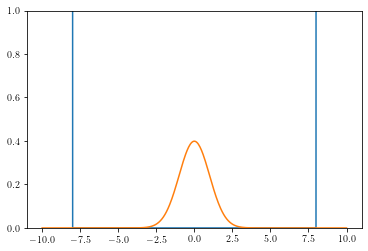

In [3]:
L = 20
M = 400
X = np.linspace(-L/2,L/2,M)
dx = X[1]-X[0]
dt = 0.0001
b=0

# define potential of two high potential wells
vecV = 10*(np.tanh((X-8)/0.001)+1)-10*(np.tanh((X+8)/0.001)-1)

# set initial state with a gaussian-shape density
mu = 0
std = 1
snd = stats.norm(mu, std)

plt.plot(X,vecV);
plt.plot(X, snd.pdf(X))
plt.ylim((0,1));
plt.show()

In [4]:
# set the state into a motion with velocity v
v=5
psi =  np.sqrt(snd.pdf(X))*np.exp(1j*v*X)

# generate matrices
IOp = InvOplus(vecV, dx, dt, b)
Om  = Ominus(vecV, dx, dt, b)

Nsteps = 375
Nsaves= 400
W = evolution(IOp, Om, Nsaves, Nsteps, psi, vecV, dx, dt)

time = 0.0375 , energy = (12.55578157-0j) , norm = 1.0
time = 1.5375 , energy = (12.5557756-1.01e-06j) , norm = 1.0
time = 3.0375 , energy = (12.55577663+5e-08j) , norm = 1.0
time = 4.5375 , energy = (12.55576894+2e-08j) , norm = 1.0
time = 6.0375 , energy = (12.55577759+2.3e-07j) , norm = 1.0
time = 7.5375 , energy = (12.55577627-8e-08j) , norm = 1.0
time = 9.0375 , energy = (12.55577651-9e-08j) , norm = 1.0
time = 10.5375 , energy = (12.55577437+1.2e-07j) , norm = 1.0
time = 12.0375 , energy = (12.55577351-1.2e-07j) , norm = 1.0
time = 13.5375 , energy = (12.55577716+4.4e-07j) , norm = 1.0


In [10]:
# Enable interactive plot
#%matplotlib notebook

#from matplotlib import animation

#fig, ax = plt.subplots()
#line, = ax.plot([])
#ax.set_xlim(-L/2,L/2);
#ax.set_ylim(0, 0.8);
#ax.plot(X,vecV,color='black');
#plt.xlabel("position",size=15);
#plt.xticks(size=15);
#plt.yticks(size=15);

#def animate(frame_num):
#    Y = np.absolute( W[0][frame_num] )**2
#    line.set_data((X, Y))
#    ax.legend([r"$|\psi|^2$"+" at time = " + str( round( frame_num*dt*Nsteps,1))],fontsize=20);
#    return line

#anim = animation.FuncAnimation(fig, animate, frames=len(W[0]), interval=60)
#plt.show()

#from IPython.display import HTML
#HTML(anim.to_jshtml())
#HTML(anim.to_html5_video())

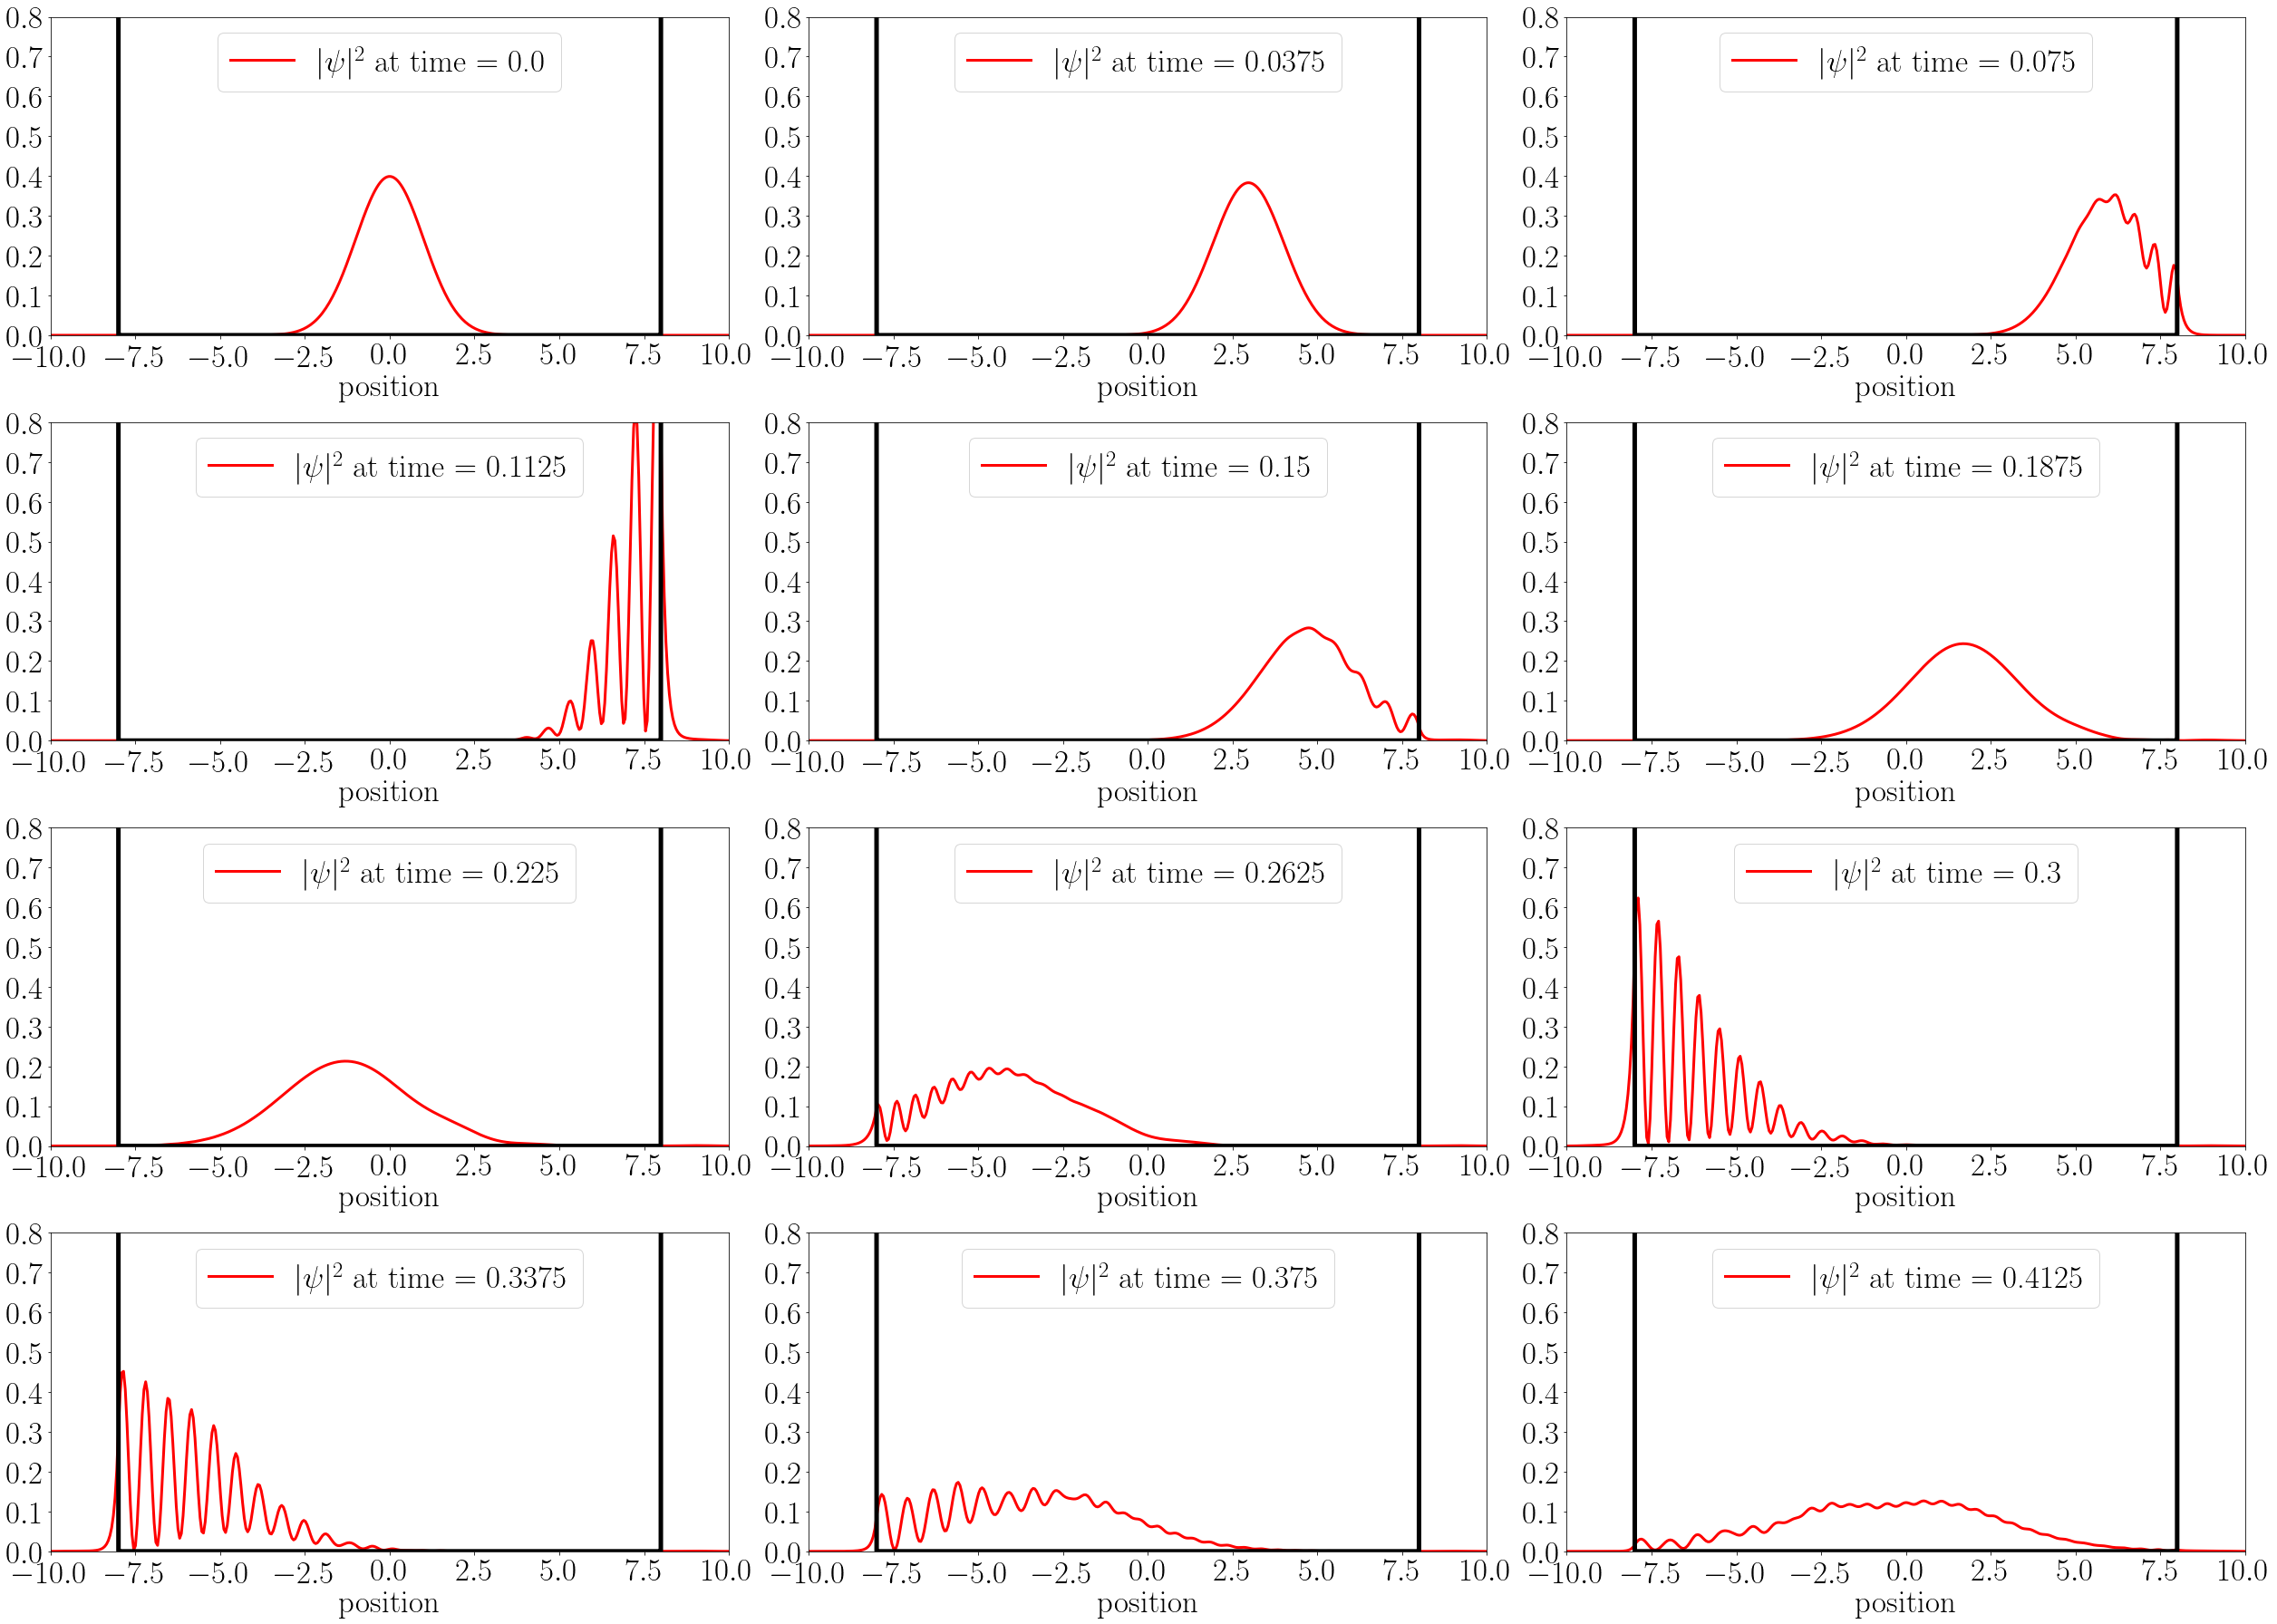

In [46]:
rr = int(len(W[0])/24)
for q in range(0,12):
    plt.subplot(4,3,q+1)
    plt.ylim((0,0.8));
    plt.xlim((-L/2,L/2));
    Y = np.absolute( W[0][rr*q] )**2
    plt.plot(X,Y, color='red', linewidth=3)
    plt.xlabel("position",size=35);
    plt.xticks(size=35);
    plt.yticks(size=35);
    plt.legend([r"$|\psi|^2$"+" at time = " + str( round( q*dt*Nsteps,4))],fontsize=35);
    plt.plot(X,vecV,color='black',linewidth=5);
    fig = mpl.pyplot.gcf()
    fig.set_size_inches(35, 25)
plt.tight_layout()

In [23]:
s

401